In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd
import torch

## Dataset creation with hybrid model

In [4]:
attributes = ['title','authors','venue','year']

In [24]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/dblp_acm_hybrid2.pth')
hybrid_model = hybrid_model.cuda()

In [25]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,
                             '../../datasets/Structured/DBLP-ACM','test_negatives',0)

In [26]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,
                             '../../datasets/Structured/DBLP-ACM','test_positives',1)

In [27]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM','positives',1)

In [28]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM','negatives',0)

In [29]:
## Basta scegliere un campione a caso
classifier_len = len(list(testneg.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Ri discovery

### Negatives

In [30]:
testneg_ri,testneg_ri_norms = computeRi(hybrid_model.classifier,attributes,testneg,0)
torch.save(testneg_ri,'experiment_results/testneg_ri_hybrid.pt')


  8%|▊         | 152/2016 [00:43<08:40,  3.58it/s]


 15%|█▌        | 305/2016 [01:23<07:05,  4.02it/s]


 23%|██▎       | 457/2016 [02:03<06:30,  3.99it/s]


 30%|███       | 608/2016 [02:44<06:26,  3.64it/s]


 38%|███▊      | 760/2016 [03:28<05:59,  3.50it/s]


 45%|████▌     | 912/2016 [04:08<04:56,  3.73it/s]


 53%|█████▎    | 1062/2016 [04:47<04:07,  3.86it/s]


 60%|██████    | 1210/2016 [05:28<03:48,  3.53it/s]


 67%|██████▋   | 1359/2016 [06:10<03:10,  3.45it/s]


 75%|███████▍  | 1507/2016 [06:53<02:21,  3.59it/s]


 82%|████████▏ | 1656/2016 [07:36<01:44,  3.44it/s]


 90%|████████▉ | 1805/2016 [08:19<01:00,  3.50it/s]


 97%|█████████▋| 1955/2016 [09:01<00:16,  3.80it/s]


100%|██████████| 2016/2016 [09:17<00:00,  3.62it/s]


In [31]:
testneg_ri_norms.to_csv('experiment_results/testneg_ri_norms_hybrid.csv',index=False)

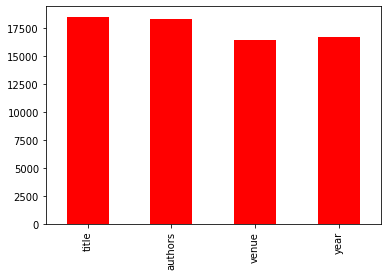

In [32]:
testneg_ri_norms.drop(['sample_id'],axis=1).sum(numeric_only=True).plot.bar(color='red')

### Positives

In [33]:
testpos_ri,testpos_ri_norms = computeRi(hybrid_model.classifier,attributes,testpos,1)
torch.save(testpos_ri,'experiment_results/testpos_ri_hybrid.pt')


 37%|███▋      | 164/442 [00:40<00:57,  4.85it/s]


 75%|███████▍  | 330/442 [01:16<00:25,  4.40it/s]


100%|██████████| 442/442 [01:42<00:00,  4.30it/s]


In [34]:
testpos_ri_norms.to_csv('experiment_results/testpos_ri_norms_hybrid.csv',index=False)

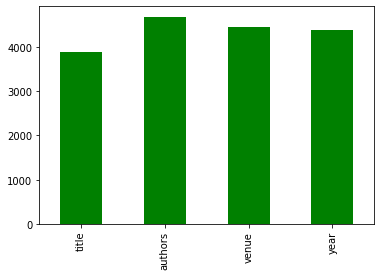

In [35]:
testpos_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

## Nearest neighbors discovery

In [18]:
from utils.distance_measures import nearestNeighborOnAttributes

In [19]:
testneg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')
testpos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')

In [20]:
negatives_closer_vectors_df = nearestNeighborOnAttributes(testneg,testneg_ri,positives,attributes,attribute_len,
                                                         min_similarity=-1)

100%|██████████| 2016/2016 [00:05<00:00, 390.38it/s]


In [21]:
negatives_closer_vectors_df.to_csv('experiment_results/testnegNN_hybrid.csv',index=False)

In [22]:
positives_closer_vectors_df = nearestNeighborOnAttributes(testpos,testpos_ri,negatives,
                                                                      attributes,attribute_len,
                                                                       min_similarity=-1)

100%|██████████| 442/442 [00:02<00:00, 157.24it/s]


In [23]:
positives_closer_vectors_df.to_csv('experiment_results/testposNN_hybrid.csv',index=False)

## Correct rankings

In [9]:
from utils.distance_measures import smallestDistanceOnAttributes,correctRankings

In [16]:
testpos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')
testneg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')

In [17]:
testpos_nn_distances = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 442/442 [00:02<00:00, 190.07it/s]


In [18]:
testneg_nn_distances = smallestDistanceOnAttributes(testneg,testneg_ri,
                                                        positives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 2016/2016 [00:03<00:00, 582.69it/s]


In [27]:
corrected_rankings_testneg = correctRankings(testneg_ri_norms,testneg_nn_distances)
corrected_rankings_testpos = correctRankings(testpos_ri_norms,testpos_nn_distances)

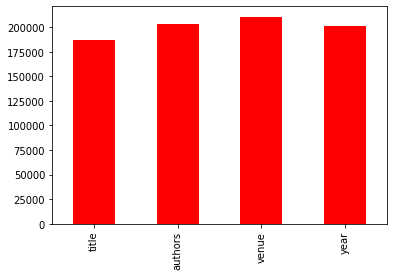

In [28]:
corrected_rankings_testneg.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

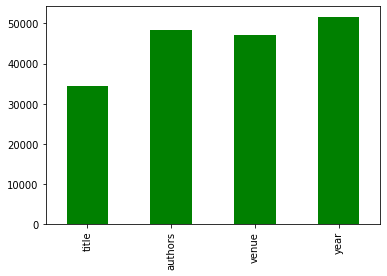

In [29]:
corrected_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

In [30]:
testneg_nn_distances.mean()

title            9.977295
authors         11.040659
venue           12.887423
year            11.953418
sample_id    11319.663194
dtype: float64

In [31]:
testpos_nn_distances.mean()

title            7.232829
authors          9.491521
venue            9.830073
year             9.538123
sample_id    11352.171946
dtype: float64

## Try extended datasets

In [20]:
ext_positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM','extended_positives',1)

In [22]:
ext_negatives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM','extended_negatives',0)

In [23]:
testpos_nn_distances_ext = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       ext_negatives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 442/442 [00:03<00:00, 142.41it/s]


In [24]:
testneg_nn_distances_ext = smallestDistanceOnAttributes(testneg,testneg_ri,
                                                        ext_positives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 2016/2016 [00:04<00:00, 467.02it/s]


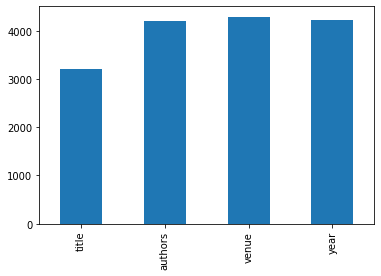

In [27]:
testpos_nn_distances_ext.drop(['sample_id'],axis=1).sum().plot.bar()

In [28]:
len(ext_positives.keys())

3144

In [32]:
len(ext_negatives.keys()),len(negatives.keys())

(13918, 10107)